 # Py: LLM Unstructured Text Transformation
  *Leverage Large Language Models to extract structured data from free-form text for actuarial analysis*

  ***By Alice Tran***

 ## Introduction

 Actuaries increasingly encounter free-form text data across various aspects of their work. Whether it's analyzing **claim diaries** that capture detailed notes about claim investigations, **customer feedback** from policy reviews, **underwriting notes** documenting risk assessments, or **regulatory correspondence** containing compliance-related communications, the ability to extract meaningful insights from unstructured text has become a critical skill.

 Traditional approaches to text analysis often rely on keyword searches or basic sentiment analysis tools, which can miss nuanced patterns and context. Large Language Models (LLMs) offer a powerful alternative, capable of transforming unstructured text into structured data that can be used for exploratory data analysis, predictive modeling, and business intelligence.

 In this tutorial, we'll demonstrate how to use LLMs to analyze customer reviews of travel insurance policies, extracting sentiment, categorizing feedback types, and identifying specific issues. This approach can be adapted for various actuarial applications where text analysis is needed.
 The tutorial continues on from the previous tutorial on [sentiment analysis using old natural language programming](https://actuariesinstitute.github.io/cookbook/docs/DAA_M07_CS2.html)

In [ ]:
import json
import ollama
from openai import OpenAI
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

 ## Setting Up the LLM Client

 The key advantage of using Ollama with the OpenAI-compatible API is **flexibility**. By simply changing the `base_url` parameter, you can switch between local and cloud-based models without changing your code structure.

 When working with potentially sensitive data, privacy is a consideration. Running models locally is one approach to maintain data confidentiality.
 This tutorial uses **Ollama** with the OpenAI-compatible API, giving you the flexibility to choose between:

 - **Local models** (via Ollama): Complete data privacy, no external API calls, but requires local compute resources
 - **Cloud-based models** (via OpenAI API): More powerful models with faster processing, but data is sent to external services

 **For local models (Ollama):**
 - Set `base_url='http://localhost:11434/v1'`
 - Use any model name available in your local Ollama installation

 **For OpenAI models:**
 - Set `base_url='https://api.openai.com/v1'`
 - Use your actual OpenAI API key
 - Choose from models like 'gpt-3.5-turbo', 'gpt-4', etc.


In [ ]:
# Initialize the OpenAI client to point to your LOCAL Ollama server
# This configuration ensures all data processing happens locally for privacy
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama',  # required but ignored by Ollama, can be anything
)

 ## Configuration Parameters

 We'll define our key parameters upfront for easy modification. The model name should correspond to a model available in your local Ollama installation. Popular choices include:
 - `llama3.2`: Good balance of performance and resource usage
 - `mistral`: Strong performance on analytical tasks
 - `gemma:2b`: Lightweight option for resource-constrained environments

In [ ]:
# Configuration parameters
MODEL_NAME = 'llama3.2'  # Or 'llama3.2', 'mistral', 'gemma:2b', etc.
INPUT_CSV = 'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/DAA_M07_CS2_data.csv.zip'
OUTPUT_CSV = 'reviews_with_extracted_claims_data.csv'

 ## Data Loading and Initial Exploration

 We'll work with a dataset of travel insurance customer reviews. This dataset is representative of the type of unstructured text data that actuaries might encounter when analyzing customer satisfaction, claim patterns, or product performance.

 We'll limit our analysis to the first 50 reviews to keep processing time manageable while still showcasing the methodology.
 We will also pretend the review score is not there for the purpose of this tutorial - but there is a comparison at the end.

In [ ]:
# Load the customer review data
try:
    df = pd.read_csv(
        INPUT_CSV,
        encoding='cp1252'
    )
    df = df.head(50)  # Limit to 50 reviews for demonstration    
    df['full_review'] = df['title'] + ": " + df['body'] # Get full review text combining title and body
    print(f"Loaded {len(df)} reviews from '{INPUT_CSV}'.")
    print(f"Dataset shape: {df.shape}")
    print(f"Column names: {list(df.columns)}")
    print(f"\nSample review:\n{df['full_review'].iloc[0][:200]}...")
except FileNotFoundError:
    print(f"Error: The file '{INPUT_CSV}' was not found.")
    exit()

Loaded 50 reviews from 'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/DAA_M07_CS2_data.csv.zip'.
Dataset shape: (50, 7)
Column names: ['pubDate', 'rating', 'title', 'body', 'url', 'pubMonth', 'full_review']

Sample review:
Excellent value.: I used this travel insurance mainly for the car hire excess. I paid $108 for cover for a family of 5, compared to the car company  excess only insurance of $200. Booking online very ...


 ## The LLM Analysis Function: From Unstructured to Structured

 This is where the magic happens. We'll create a comprehensive function that takes raw review text and extracts multiple structured data points:

 1. **Sentiment Classification**: Positive, Negative, or Neutral
 2. **Feedback Categorization**: What aspect of the service is being discussed
 3. **Specific Issue Identification**: The particular event or item mentioned

 The key to effective LLM prompting for actuarial applications is **precision and consistency**. We provide clear categories and examples to ensure reliable, standardized output that can be used for downstream analysis.

In [ ]:
def extract_full_analysis(review_text: str) -> dict:
    """
    Analyzes a review and extracts sentiment, feedback category and specific issue
    as a single JSON object.
    
    This function demonstrates how to use LLMs to transform unstructured text
    into structured data suitable for actuarial analysis.
    """
    # Comprehensive prompt designed for consistent, structured output
    prompt = f"""
You are a senior Customer Experience Analyst. Your task is to analyze the following review
and return a single, valid JSON object and nothing else.

1. "sentiment": Classify the sentiment. Must be one of: "Positive", "Negative", or "Neutral".
2.  "feedback_category": Classify the primary subject of the customer's feedback. Must be one of the following strings:
    - "Product Design & Wording": Feedback on policy coverage, exclusions, price, or clarity of the Product Disclosure Statement (PDS).
    - "Sales & Purchase Process": Feedback on the experience of buying the policy online or via an agent.
    - "Claims Process": Feedback on the experience of submitting, managing, or the outcome of a formal claim.
    - "Customer Support & Communication": Feedback on general interactions with staff via phone or email.
    - "Emergency Assistance (24/7 Support)": Specific feedback on using the emergency helpline during a trip.
    - "Factual Claim Notification": The customer is stating facts to lodge a claim without providing feedback on service or product yet.
3.  "specific_issue": Identify the specific event or item mentioned (e.g., "flight cancellation", "lost baggage", "confusing PDS", "helpful agent"). If none, use "N/A".

Review:
"{review_text}"

JSON Output:"""

    try:
        # Use Ollama's chat function with JSON formatting for reliable structured output
        response = ollama.chat(
            model=MODEL_NAME,
            messages=[{'role': 'user', 'content': prompt}],
            format='json',  # Ensures output is valid JSON
            options={'temperature': 0}  # Deterministic output for consistency
        )
        
        # Parse and return the structured response
        data = json.loads(response['message']['content'])
        return data
            
    except (json.JSONDecodeError, KeyError):
        # Safety net for rare cases where the output is not valid JSON
        return {'sentiment': 'Error', 'feedback_category': 'Error', 'specific_issue': 'Error'}
    except Exception as e:
        print(f"\nAn error occurred: {e}")
        return {'sentiment': 'Error', 'feedback_category': 'Error', 'specific_issue': 'Error'}

 ## Batch Processing and Data Transformation

 Now we'll apply our LLM analysis function to the entire dataset. This process transforms each unstructured review into three structured data points, dramatically expanding our analytical capabilities.

 The `tqdm` library provides a progress bar, which is particularly useful when processing large datasets. The `pd.json_normalize` function elegantly converts the nested JSON responses into DataFrame columns.

In [ ]:
# Apply the LLM analysis function to review sample
tqdm.pandas(desc=f"Performing analysis with {MODEL_NAME}")

# The result will be a Series of dictionaries
results_series = df['full_review'].progress_apply(extract_full_analysis)

# Use pd.json_normalize to elegantly convert the dictionaries into DataFrame columns
results_df = pd.json_normalize(results_series)

# Combine the new structured data with our original DataFrame
df = pd.concat([df.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

print("\nFull data extraction complete.")
df.to_csv(OUTPUT_CSV, index=False)
print(f"Results saved to '{OUTPUT_CSV}'.")
print("\nSample of the final, enriched DataFrame:")
print(df[['body', 'sentiment', 'feedback_category', 'specific_issue']].head())

Performing analysis with llama3.2: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


Full data extraction complete.
Results saved to 'reviews_with_extracted_claims_data.csv'.

Sample of the final, enriched DataFrame:
                                                body sentiment  \
0  I used this travel insurance mainly for the ca...  Positive   
1  We took out a cover more policy for a quick 10...  Positive   
2  My wife developed a medical condition so we ha...  Negative   
3  Prices getting more expensive as we get older ...  Positive   
4  needed to make a claim when I had to cut short...  Positive   

                  feedback_category  \
0          Product Design & Wording   
1  Customer Support & Communication   
2          Product Design & Wording   
3          Product Design & Wording   
4                    Claims Process   

                                  specific_issue  
0                                            N/A  
1                                  Great service  
2                    tricked up Insurance Policy  
3  Prices getting more expensiv

 ## Root Cause Analysis: Identifying Key Issues

 With our text data now structured, we can perform analysis to identify patterns and root causes - and look to understand:

 - **Risk factors**: What issues lead to claims or customer dissatisfaction?
 - **Process improvements**: Where are the bottlenecks in customer experience?
 - **Product development**: What features or coverage gaps need attention?

 We'll focus on negative reviews to identify the primary drivers of customer dissatisfaction.

In [ ]:
# Filter to focus on negative reviews for root cause analysis
negative_df = df[df['sentiment'] == 'Negative'].copy()

print(f"\n--- Root Cause Analysis for {len(negative_df)} Negative Reviews ---")
print(f"Negative sentiment rate: {len(negative_df)/len(df)*100:.1f}%")

if negative_df.empty:
    print("No negative reviews were found to analyze.")
else:
    # Display distribution of feedback categories in negative reviews
    print("\nBreakdown of negative feedback by category:")
    print(negative_df['feedback_category'].value_counts())


--- Root Cause Analysis for 13 Negative Reviews ---
Negative sentiment rate: 26.0%

Breakdown of negative feedback by category:
feedback_category
Product Design & Wording            7
Customer Support & Communication    4
Claims Process                      2
Name: count, dtype: int64



 ## Primary Drivers of Negative Sentiment by Category

 This visualization helps identify which aspects of the travel insurance service are causing the most dissatisfaction. For actuaries, this information is crucial for:

 - **Risk assessment**: Understanding which processes have the highest failure rates
 - **Resource allocation**: Prioritizing improvement efforts where they'll have the most impact
 - **Product pricing**: Factoring in customer experience risks to pricing models

<ipython-input-8-6cff36d9f359>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=negative_df, y='feedback_category',


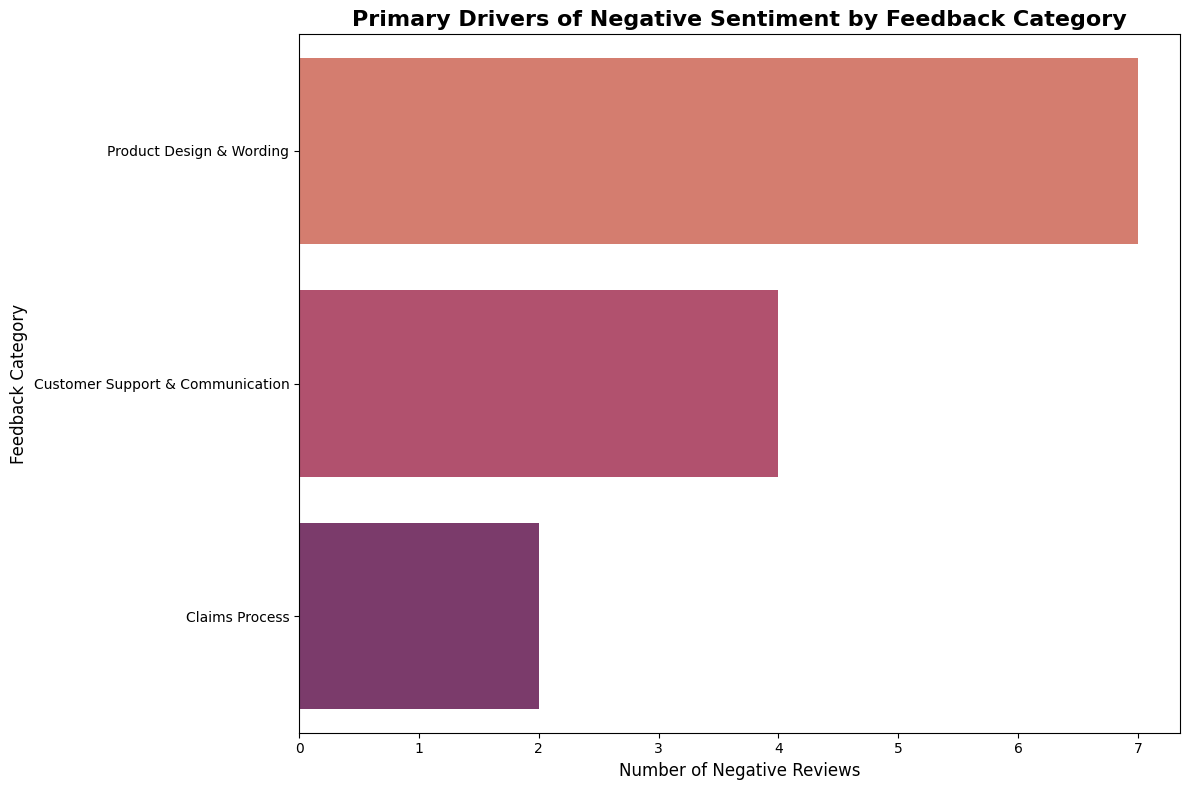


Top negative feedback category: Product Design & Wording
This represents 7 out of 13 negative reviews


In [ ]:
if not negative_df.empty:
    # Analysis 1: Primary drivers of negative sentiment by feedback category
    plt.figure(figsize=(12, 8))
    sns.countplot(data=negative_df, y='feedback_category', 
                  order=negative_df['feedback_category'].value_counts().index, 
                  palette="flare")
    plt.title('Primary Drivers of Negative Sentiment by Feedback Category', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Number of Negative Reviews', fontsize=12)
    plt.ylabel('Feedback Category', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop negative feedback category: {negative_df['feedback_category'].value_counts().index[0]}")
    print(f"This represents {negative_df['feedback_category'].value_counts().iloc[0]} out of {len(negative_df)} negative reviews")

 ## Specific Issues Driving Negative Sentiment

 While categories tell us the general area of concern, specific issues may provide actionable insights.
 We can sample a few specific issues to look for operational failure points or customer journey pain points.

In [ ]:
if not negative_df.empty:
    # Analysis 2: Specific issues driving negative sentiment
    # Filter out 'N/A' values and get top issues
    specific_issues = negative_df[negative_df['specific_issue'] != 'N/A']['specific_issue'].value_counts()
    
    if not specific_issues.empty:
        from IPython.display import display
        # Show top 10 specific issues
        top_issues = specific_issues.head(10)
        display(top_issues)

specific_issue
tricked up Insurance Policy                     1
lost baggage                                    1
broken surfboard                                1
Corona virus coverage                           1
family policy exclusion                         1
incorrect birth dates on certificate            1
delayed claim processing and lack of support    1
Policy interpretation and lack of clarity       1
poor service                                    1
unhelpful agent                                 1
Name: count, dtype: int64

 ## Summary and Next Steps

 This tutorial has demonstrated how LLMs can transform unstructured text data into structured insights valuable for actuarial analysis.
 We converted free-form reviews into structured sentiment, category, and issue data.
 The code optionally uses local LLM processing to maintain data confidentiality.
 With the structured data, one can identify primary drivers of customer dissatisfaction and potentially find actionable insights.

 The overall approach is generalisable - and may have other applications for actuaries - for example:
 - **Claim Analysis**: Extract patterns from claim diaries and adjuster notes
 - **Underwriting Risk Assessment**: From freeform underwriting notes
 - **Product Development**: Understand coverage from products of the business and its competitors
 - **Customer Experience**: Quantify service quality impacts on retention and satisfaction


 ## Additional Analysis: Sentiment Distribution

 Let's conclude with an overall view of sentiment distribution across the reviews to
 see how the LLM has fared in reading the text compared to the true review score.

<Figure size 1200x800 with 0 Axes>

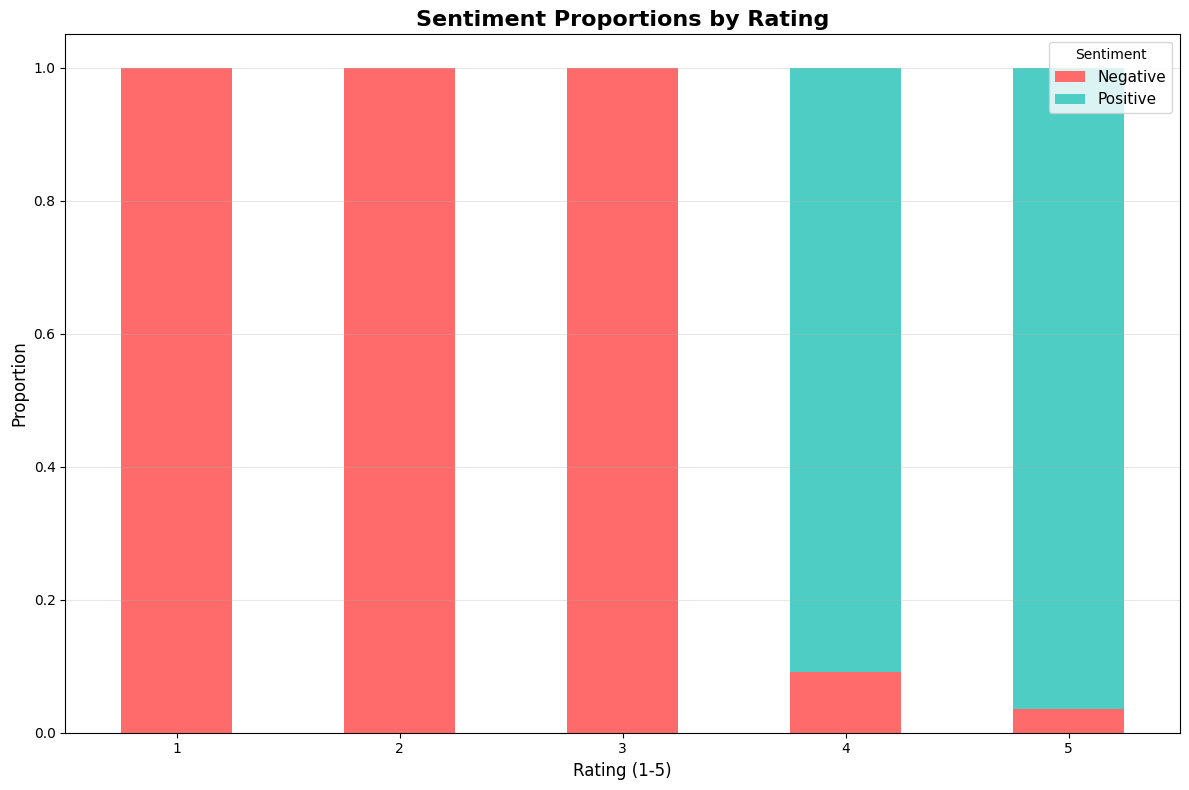

In [ ]:
# Overall sentiment distribution
# Create the stacked bar chart showing proportion of sentiments within each rating
plt.figure(figsize=(12, 8))

# Calculate sentiment proportions by rating
rating_sentiment_props = df.groupby('rating')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Create the stacked bar chart
rating_sentiment_props.plot(kind='bar', stacked=True, 
                           color=['#ff6b6b', '#4ecdc4', '#45b7d1'],
                           figsize=(12, 8))

plt.title('Sentiment Proportions by Rating', fontsize=16, fontweight='bold')
plt.xlabel('Rating (1-5)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Sentiment', fontsize=11)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

 It appears the LLM reading of the reviews is fairly consistent with the sentiment distribution.

 ---

 *This tutorial demonstrates how by leveraging LLMs to structure unstructured data, actuaries can unlock new insights from text sources that were previously difficult to analyze systematically.*